In [1]:
import sys
ROOT_DIR = "../.."
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

In [2]:
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import h5py as h5
import time
import datetime
from matplotlib.colors import LogNorm
from sklearn.metrics.pairwise import euclidean_distances
from tqdm import tqdm

import pysingfel as ps
import pysingfel.gpu as pg

Psana functionality is not available.


In [3]:
def show_ds(experiment, dataset):
    N = dataset.shape[0]
    plt.figure(figsize=(20, 20/N+1))
    for i in range(N):
        plt.subplot(1, N, i+1)
        img = experiment.det.assemble_image_stack(dataset[i])
        plt.imshow(img, norm=LogNorm())
    plt.show()

In [4]:
beam = ps.Beam(photon_energy=4600, fluence=1e12, focus_radius=1e-7)

In [5]:
particle = ps.Particle()
particle.read_pdb(ROOT_DIR+'/examples/input/pdb/2CEX.pdb', ff='WK')

Unknown element or wrong line: 
 HETATM 9529 ZN    ZN A1306      16.516   1.920  -2.897  0.50 39.31          ZN  

Unknown element or wrong line: 
 HETATM 9562 ZN    ZN B1310      79.517  -6.890  29.691  1.00 30.08          ZN  

Unknown element or wrong line: 
 HETATM 9563 ZN    ZN B1311      54.463  32.835  14.529  0.50 32.48          ZN  

Unknown element or wrong line: 
 HETATM 9564 ZN    ZN C1306      14.881  -6.161  50.429  1.00 30.87          ZN  

Unknown element or wrong line: 
 HETATM 9565 ZN    ZN C1307      22.417 -36.707  14.694  0.50 53.28          ZN  

Unknown element or wrong line: 
 HETATM 9572 ZN    ZN D1307      -6.904  24.013  20.912  0.50 21.13          ZN  



# Simple Square Detector

In [6]:
det = ps.SimpleSquareDetector(N_pixel=1024, det_size=0.1, det_distance=0.3)

In [7]:
N_images = 5

In [8]:
experiment = ps.SPIExperiment(det, beam, particle)

In [9]:
intensities = np.zeros((N_images,) + det.shape, np.float32)
photons = np.zeros((N_images,) + det.shape, np.int32)

In [10]:
for i in tqdm(range(N_images)):
    photons[i], intensities[i] = experiment.generate_image_stack(return_photons=True, return_intensities=True)

100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


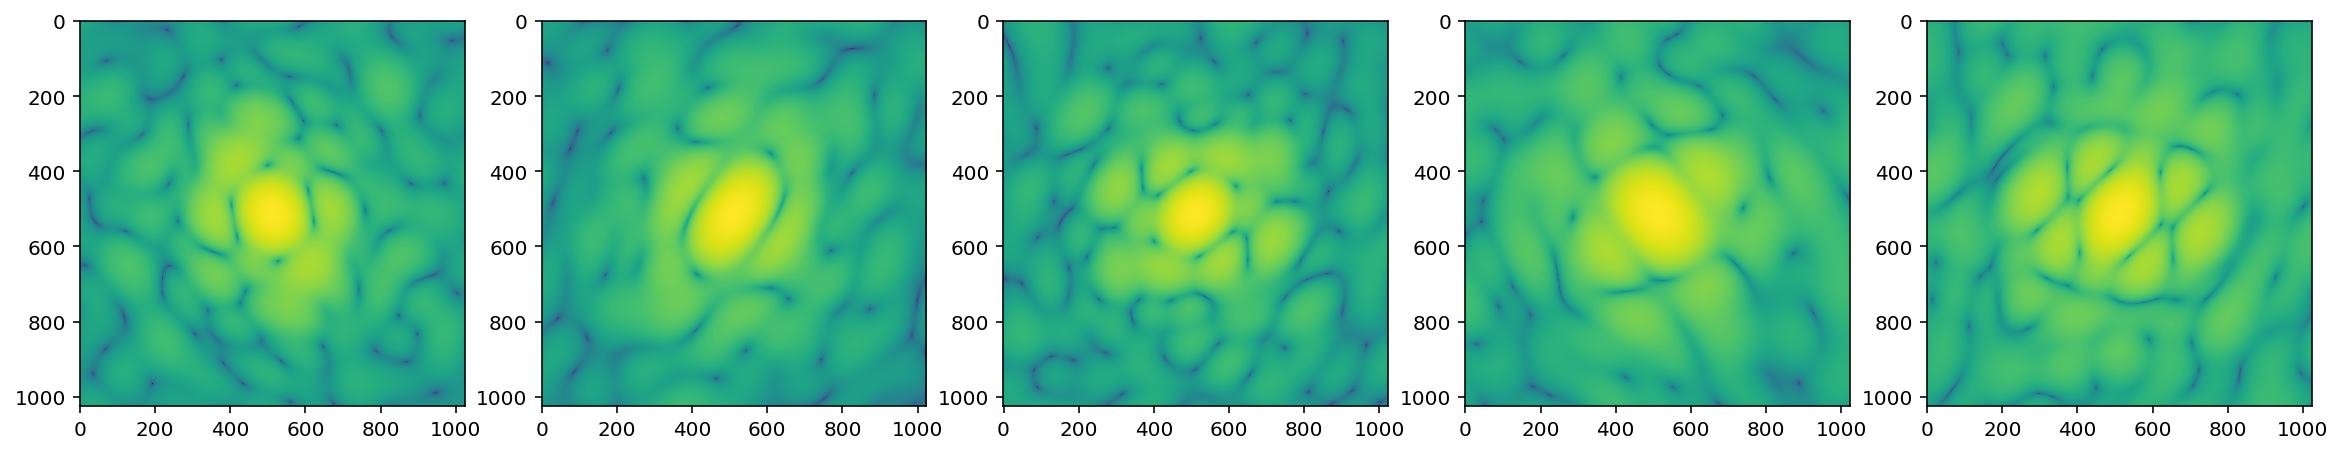

In [11]:
show_ds(experiment, intensities)

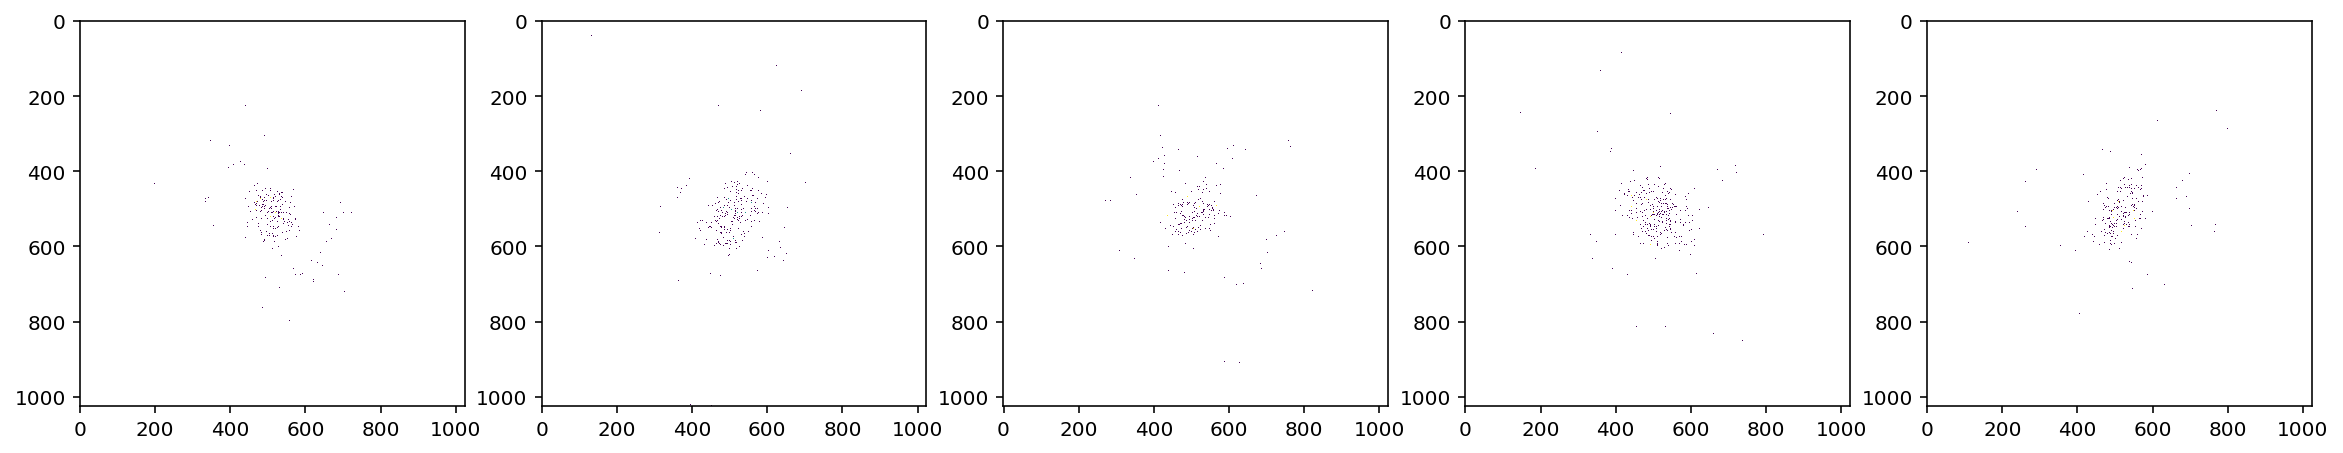

In [12]:
show_ds(experiment, photons)

# Personalized Detector

In [13]:
# Creating a two-pannels detector
det_shape = (2, 256, 256)
gap_size = 1e-2  # m
panel_size =  1e-1  # m
ar = np.arange(256)
sep = panel_size / 256
x = gap_size/2 + sep/2 + ar*sep
y = -panel_size/2 + sep/2 + ar*sep
assert np.isclose(-y.min(), y.max())
X, Y = np.meshgrid(x, y, indexing='xy')
Xar, Yar = np.meshgrid(ar, ar, indexing='xy')

In [14]:
p_center_x = np.stack((X-gap_size-panel_size, X))
p_center_y = np.stack((Y, Y))

In [15]:
# Assembling the pixel index map.
# It maps each pixel of the detector
# to its ij-position in a 2D assembled image.
p_map_x = np.stack((Xar, Xar + 256 + int(gap_size/sep)))
p_map_y = np.stack((Yar, Yar))
p_map = np.stack((p_map_x, p_map_y), axis=-1)
# You can create a detector without it
# if not using det.assemble_image_stack
# to assemble the image.

In [16]:
det_dict = {
    'panel number': 2,
    'panel pixel num x': 256,
    'panel pixel num y': 256,
    'detector distance': 0.2,
    'pixel width': sep * np.ones(det_shape),  # Width of each pixel
    'pixel height': sep * np.ones(det_shape),  # Height of each pixel
    'pixel center x': p_center_x,  # X-coordinate of each pixel center
    'pixel center y': p_center_y,  # Y-coordinate of each pixel center
    'pixel map': p_map,  # Mapping to assemble image (optional for unassembled detectors)
}
det = ps.UserDefinedDetector(
    geom=det_dict,
    beam=beam)

In [17]:
experiment = ps.SPIExperiment(det, beam, particle)

In [18]:
intensities = np.zeros((N_images,) + det.shape, np.float32)
photons = np.zeros((N_images,) + det.shape, np.int32)

In [19]:
for i in tqdm(range(N_images)):
    photons[i], intensities[i] = experiment.generate_image_stack(return_photons=True, return_intensities=True)

100%|██████████| 5/5 [00:00<00:00,  6.94it/s]


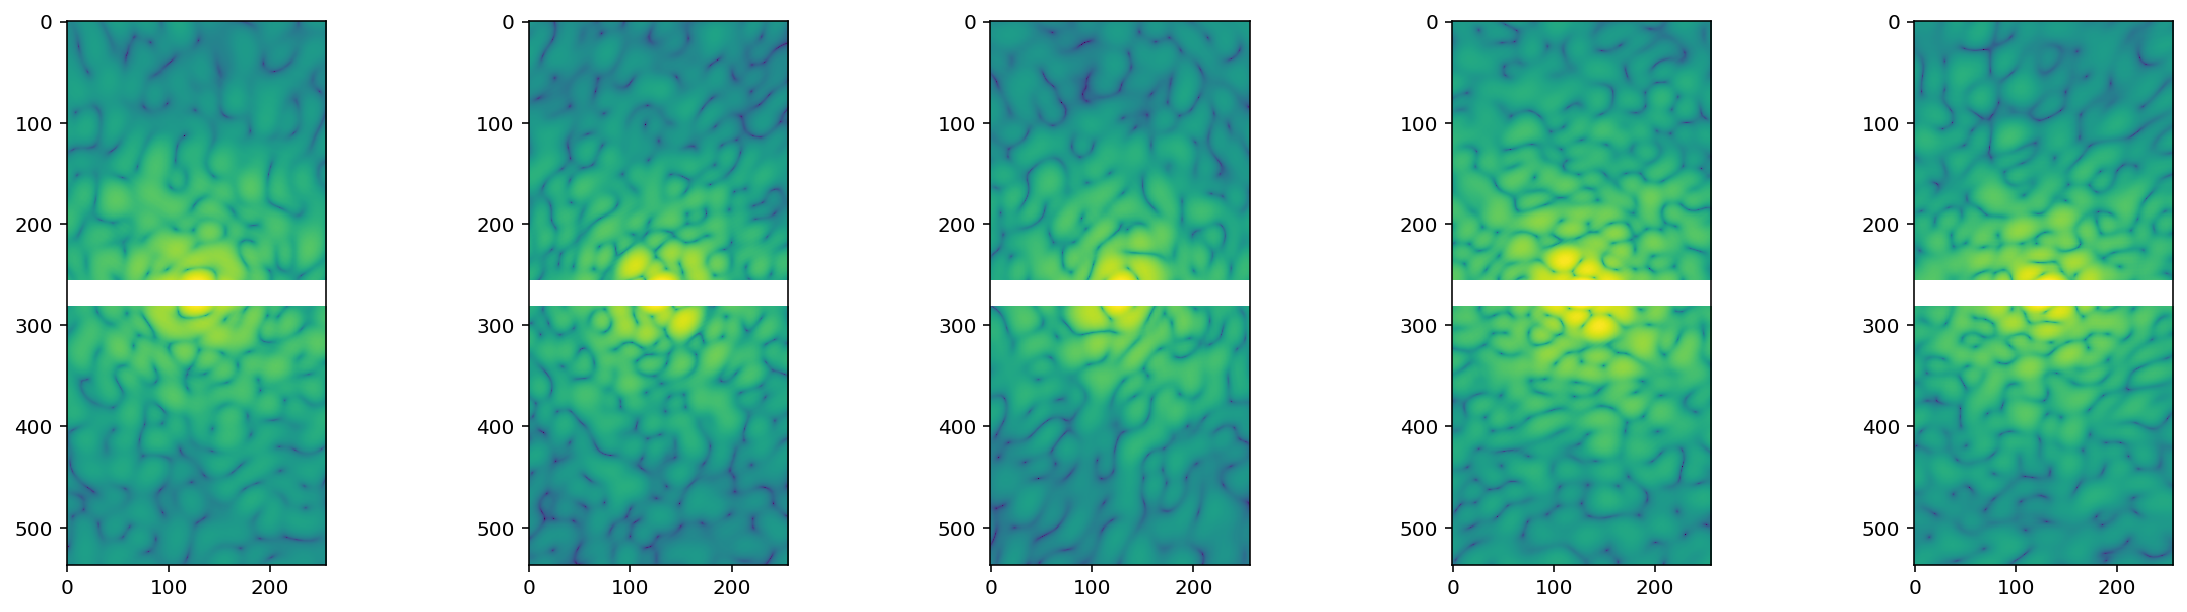

In [20]:
show_ds(experiment, intensities)

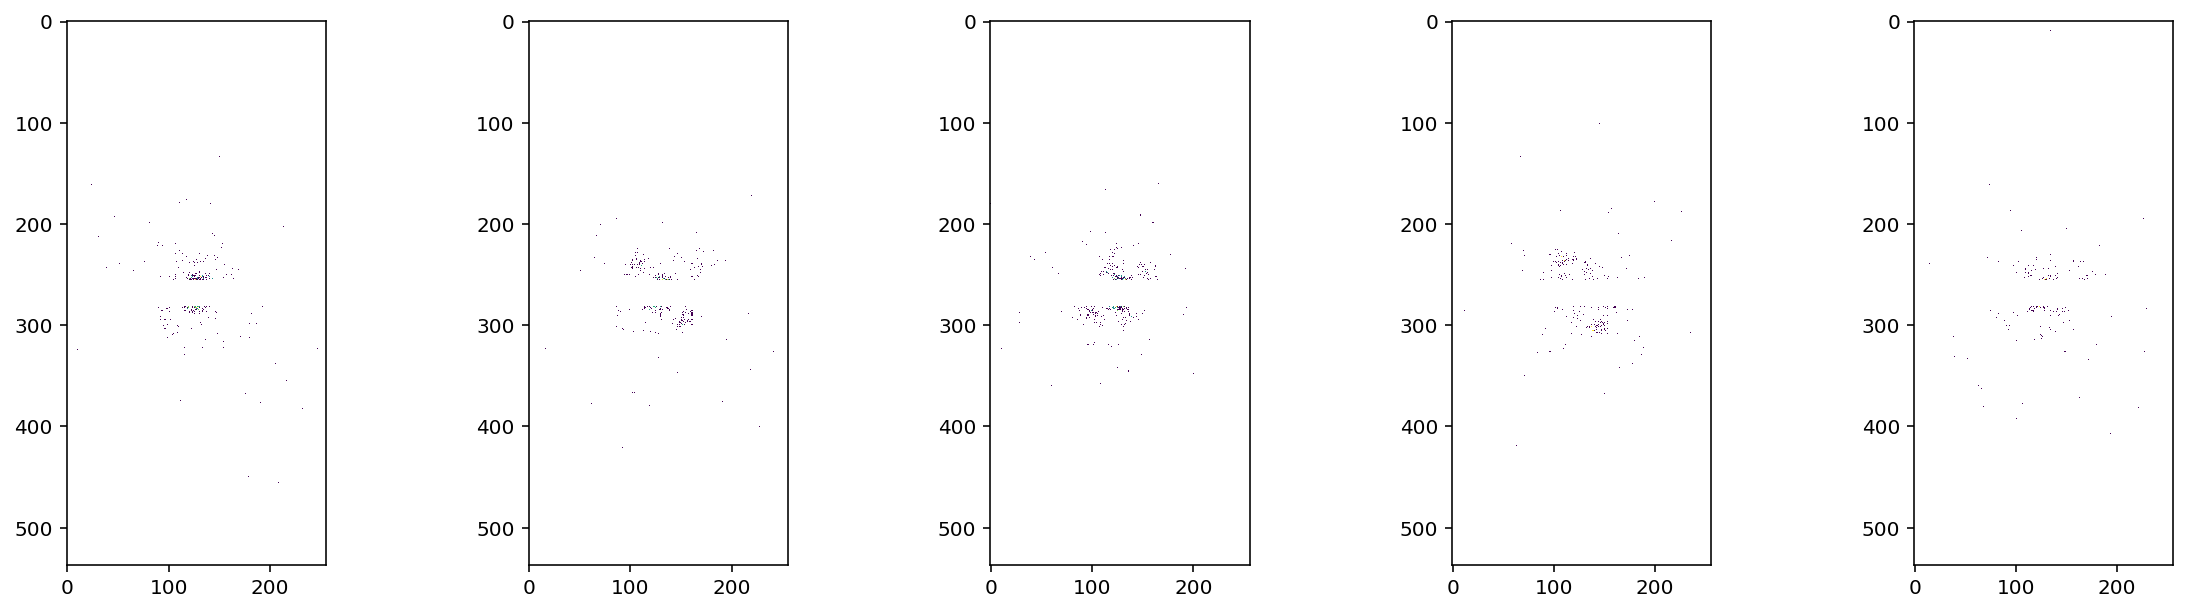

In [21]:
show_ds(experiment, photons)